In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.stats import pearsonr
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import os, sys, math
import matplotlib as mpl
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
import joblib


In [2]:
# Load all the different embeded files
#protein
k_sep_norm = pd.read_csv("../../cleaned_data/k-sep_normalized.tsv",sep="\t")
sgtembeds = pd.read_csv('../../cleaned_data/sgt_embeds.csv', index_col='Unnamed: 0')
tapembeds = pd.read_csv('../../cleaned_data/tape_embeds.csv')
elmoembeds = pd.read_csv('../../cleaned_data/elmo_embeds.csv')

ecfp4 = pd.read_csv("../../cleaned_data/ECFP4.tsv",sep="\t")  #compound

In [3]:
tapembeds['target_id'] = tapembeds['Unnamed: 0']
elmoembeds['target_id'] = elmoembeds['Unnamed: 0']
tapembeds.drop('Unnamed: 0', axis=1, inplace=True)
elmoembeds.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
#train dataset
df_tr = pd.read_csv("../../cleaned_data/traincomps.tsv",sep="\t")
df_vl = pd.read_csv("../../cleaned_data/validation_set_6195.tsv",sep="\t")

In [5]:
#train dataset with protein-compound feature vectors
pssm = df_tr.merge(k_sep_norm,on="target_id").merge(ecfp4,on="compound_id")
sgt = df_tr.merge(sgtembeds,on="target_id").merge(ecfp4,on="compound_id")
tape = df_tr.merge(tapembeds,on="target_id").merge(ecfp4,on="compound_id")
elmo = df_tr.merge(elmoembeds,on="target_id").merge(ecfp4,on="compound_id")

In [6]:
#validation dataset with protein-compound feature vectors
pssm_vl = df_vl.merge(k_sep_norm,on="target_id").merge(ecfp4,on="compound_id")
sgt_vl = df_vl.merge(sgtembeds,on="target_id").merge(ecfp4,on="compound_id")
tape_vl = df_vl.merge(tapembeds,on="target_id").merge(ecfp4,on="compound_id")
elmo_vl = df_vl.merge(elmoembeds,on="target_id").merge(ecfp4,on="compound_id")

In [7]:
pssm.shape, sgt.shape, tape.shape, elmo.shape

((87769, 1427), (87769, 1427), (87769, 1795), (87769, 2051))

In [8]:
pssm_vl.shape, sgt_vl.shape, tape_vl.shape, elmo_vl.shape

((6195, 1427), (6195, 1427), (6195, 1795), (6195, 2051))

In [ ]:
# keep some as test set
# pstrain, sgtrain = pssm.iloc[:60000,:], sgt.iloc[:60000,:]
# pstest, sgtest = pssm.iloc[60000:,:], sgt.iloc[60000:,:]
# pstrain.shape, pstest.shape, sgtrain.shape, sgtest.shape

# MLP Regressor

In [ ]:
def MLP_predictor(encoder, validata, ax, name, colors, predict):
    reg = MLPRegressor(hidden_layer_sizes=(50), alpha=0.01, max_iter=500,
                        activation='relu', solver='sgd', random_state=42)
    X_train = encoder.drop(['compound_id', 'target_id', 'pchembl_value'], axis=1)
    y_train = encoder['pchembl_value']
    X_test = validata.drop(['compound_id', 'target_id', 'pchembl_value'], axis=1)
    y_test = validata['pchembl_value']
    reg.fit(X_train, y_train)
    pred = list(reg.predict(X_test))
    truth = y_test.tolist()
    joblib.dump(reg, f'{name[i]}_MLP.pkl')
    
    dfdict = {'True Value': truth, 'Predicted Value': pred}
    df = pd.DataFrame(dfdict)
    predict[name[i]] = df
    df.plot('True Value', "Predicted Value" ,kind='scatter',s=20, ax=ax, color=colors[i], alpha=0.1)
    ax.plot((0,10), (0,10), ls="--", lw=2, c=".2", color='red')
    ax.set_xlim((2,10));  ax.set_ylim((2,10))
    pcorr = pearsonr(df['True Value'], df['Predicted Value'])[0]
    mse = mean_squared_error(df['True Value'], df['Predicted Value'])
    ax.set_title(name[i])
    ax.text(9,2.5,'pcorr=%s' %round(pcorr,2),style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    ax.text(9,3.5,'mse=%s' %round(mse,2), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    sns.despine()

In [ ]:
MLP_predict = {}
sns.set_context('notebook')
encs = [pssm, sgt, tape, elmo]
valid = [pssm_vl, sgt_vl, tape_vl, elmo_vl]
names = ['PSSM encoded sequences', 'SGT encoded sequences','TAPE encoded sequences','ELMO encoded sequences']
col = ['green', 'red', 'blue', 'purple']
fig,axs=plt.subplots(2,2,figsize=(15,12))
axs=axs.flat
for i in range(len(encs)):
    MLP_predictor(encs[i], valid[i], ax=axs[i], name=names, colors=col, predict= MLP_predict)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def rf_predictor(encoder, validata, ax, name, colors, predict):
    reg = RandomForestRegressor(n_estimators=100,max_features=0.33,random_state=42)
    X_train = encoder.drop(['compound_id', 'target_id', 'pchembl_value'], axis=1)
    y_train = encoder['pchembl_value']
    X_test = validata.drop(['compound_id', 'target_id', 'pchembl_value'], axis=1)
    y_test = validata['pchembl_value']
    reg.fit(X_train, y_train)
    pred = list(reg.predict(X_test))
    truth = y_test.tolist()
    joblib.dump(reg, f'{name[i]}_RF.pkl')
    
    dfdict = {'True Value': truth, 'Predicted Value': pred}
    df = pd.DataFrame(dfdict)
    predict[name[i]] = df
    df.plot('True Value', "Predicted Value" ,kind='scatter',s=20, ax=ax, color=colors[i], alpha=0.1)
    ax.plot((0,10), (0,10), ls="--", lw=2, c=".2", color='red')
    ax.set_xlim((2,10));  ax.set_ylim((2,10))
    pcorr = pearsonr(df['True Value'], df['Predicted Value'])[0]
    mse = mean_squared_error(df['True Value'], df['Predicted Value'])
    ax.set_title(name[i])
    ax.text(9,2.5,'pcorr=%s' %round(pcorr,2),style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    ax.text(9,3.5,'mse=%s' %round(mse,2), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    sns.despine()

In [ ]:
RF_predict = {}
sns.set_context('notebook')
encs = [pssm, sgt, tape, elmo]
valid = [pssm_vl, sgt_vl, tape_vl, elmo_vl]
names = ['PSSM encoded sequences', 'SGT encoded sequences','TAPE encoded sequences','ELMO encoded sequences']
col = ['green', 'red', 'blue', 'purple']
fig,axs=plt.subplots(2,2,figsize=(15,12))
axs=axs.flat
for i in range(len(encs)):
    rf_predictor(encs[i], valid[i], ax=axs[i], name=names, colors=col, predict= RF_predict)

# Clusters

We will first begin with elmo clusters as it seems to give 4 clusters of roughly equal sizes

In [10]:
elmoclusters = pd.read_csv('elmo_pro_cluster.csv')

In [11]:
pssmclust = pssm.merge(elmoclusters,on="target_id")
sgtclust = sgt.merge(elmoclusters,on="target_id")
tapeclust = tape.merge(elmoclusters, on='target_id')
elmoclust = elmo.merge(elmoclusters, on='target_id')

In [12]:
pssmclust_vl = pssm_vl.merge(elmoclusters,on="target_id")
sgtclust_vl = sgt_vl.merge(elmoclusters,on="target_id")
tapeclust_vl = tape_vl.merge(elmoclusters, on='target_id')
elmoclust_vl = elmo_vl.merge(elmoclusters, on='target_id')

In [22]:
def MLP_clustpred(encoder, validata, nclust, ax, name, colors, predict):
    predictions, truths = [], []
    for ind in range (0, nclust):
        reg = MLPRegressor(hidden_layer_sizes=(50), alpha=0.01, max_iter=500,
                            activation='relu', solver='lbfgs', random_state=42)
        data = encoder[encoder.cluster == ind]
        val = validata[validata.cluster == ind]
        X_train = data.drop(['compound_id', 'target_id', 'pchembl_value', 'cluster'], axis=1)
        y_train = data['pchembl_value']
        X_test = val.drop(['compound_id', 'target_id', 'pchembl_value', 'cluster'], axis=1)
        y_test = val['pchembl_value']
        reg.fit(X_train, y_train)
        predictions += reg.predict(X_test).tolist()
        truths += y_test.tolist()
        joblib.dump(reg, f'{name[i]}_MLP_elmocluster{ind}.pkl')
    
    dfdict = {'True Value': truths, 'Predicted Value': predictions}
    df = pd.DataFrame(dfdict)
    predict[name[i]] = df
    df.plot('True Value', "Predicted Value" ,kind='scatter',s=20, ax=ax, color=colors[i], alpha=0.1)
    ax.plot((0,10), (0,10), ls="--", lw=2, c=".2", color='red')
    ax.set_xlim((2,10));  ax.set_ylim((2,10))
    pcorr = pearsonr(df['True Value'], df['Predicted Value'])[0]
    mse = mean_squared_error(df['True Value'], df['Predicted Value'])
    ax.set_title(name[i])
    ax.text(9,2.5,'pcorr=%s' %round(pcorr,2),style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    ax.text(9,3.5,'mse=%s' %round(mse,2), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    sns.despine()
    

In [23]:
train1, train2, train3, train4 = pssmclust.sample(1000), sgtclust.sample(1000), tapeclust.sample(1000), elmoclust.sample(1000)
test1, test2, test3, test4 = pssmclust.sample(1000), sgtclust.sample(1000), tapeclust.sample(1000), elmoclust.sample(1000)

In [24]:
train1.head()

,compound_id,target_id,pchembl_value,k_separated_bigrams_pssm0,k_separated_bigrams_pssm1,k_separated_bigrams_pssm2,k_separated_bigrams_pssm3,k_separated_bigrams_pssm4,k_separated_bigrams_pssm5,k_separated_bigrams_pssm6,...,ECFP4.1016,ECFP4.1017,ECFP4.1018,ECFP4.1019,ECFP4.1020,ECFP4.1021,ECFP4.1022,ECFP4.1023,ECFP4.1024,cluster
60827,CHEMBL3397290,P08922,5.55,0.232550,0.424345,0.422890,0.438759,0.270651,0.306925,0.300587,...,0,0,0,0,0,0,0,0,0,1
40402,CHEMBL3672495,P31749,7.72,0.039776,0.085907,0.057778,0.093607,0.030578,0.062305,0.089368,...,0,0,0,0,0,0,0,0,0,0
16876,CHEMBL1940274,P07333,7.00,0.078665,0.185558,0.158920,0.168563,0.109214,0.116464,0.134116,...,0,0,0,0,0,0,0,0,0,1
23336,CHEMBL3806189,P00519,7.70,0.147498,0.284909,0.205784,0.236136,0.111633,0.191246,0.207284,...,0,0,0,0,1,0,0,0,0,3
30225,CHEMBL1784090,P45983,6.06,0.036499,0.117807,0.059948,0.089390,0.025776,0.062647,0.065979,...,0,0,0,0,0,0,0,0,0,0


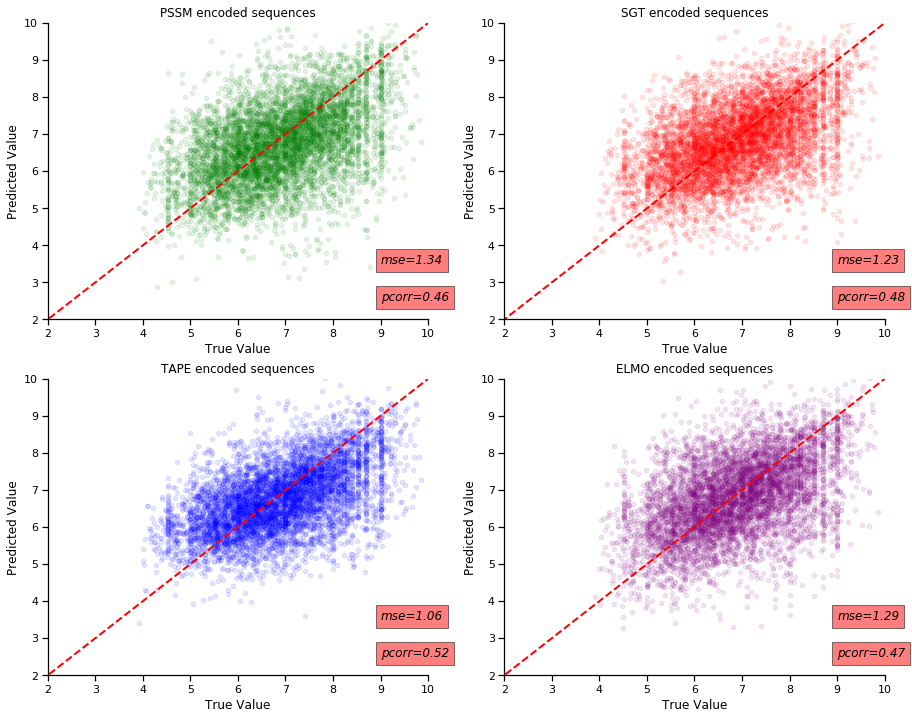

In [26]:
MLP_predict_cluster = {}
sns.set_context('notebook')
# encs = [train1, train2, train3, train4]
# valid = [test1, test2, test3, test4]
encs = [pssmclust, sgtclust, tapeclust, elmoclust]
valid = [pssmclust_vl, sgtclust_vl, tapeclust_vl, elmoclust_vl]
names = ['PSSM encoded sequences', 'SGT encoded sequences','TAPE encoded sequences','ELMO encoded sequences']
col = ['green', 'red', 'blue', 'purple']
fig,axs=plt.subplots(2,2,figsize=(15,12))
axs=axs.flat
for i in range(len(encs)):
    MLP_clustpred(encs[i], valid[i], 4, ax=axs[i], name=names, colors=col, predict= MLP_predict_cluster)

# Random forest clustered

In [28]:
def rf_clustpred(encoder, validata, nclust, ax, name, colors, predict):
    predictions, truths = [], []
    for ind in range (0, nclust):
        reg = RandomForestRegressor(n_estimators=100,max_features=0.33,random_state=42)
        data = encoder[encoder.cluster == ind]
        val = validata[validata.cluster == ind]
        X_train = data.drop(['compound_id', 'target_id', 'pchembl_value', 'cluster'], axis=1)
        y_train = data['pchembl_value']
        X_test = val.drop(['compound_id', 'target_id', 'pchembl_value', 'cluster'], axis=1)
        y_test = val['pchembl_value']
        reg.fit(X_train, y_train)
        predictions += reg.predict(X_test).tolist()
        truths += y_test.tolist()
        joblib.dump(reg, f'models/{ind}_{name[i]}_rf_elmocluster.pkl')
    
    dfdict = {'True Value': truths, 'Predicted Value': predictions}
    df = pd.DataFrame(dfdict)
    predict[name[i]] = df
    df.plot('True Value', "Predicted Value" ,kind='scatter',s=20, ax=ax, color=colors[i], alpha=0.1)
    ax.plot((0,10), (0,10), ls="--", lw=2, c=".2", color='red')
    ax.set_xlim((2,10));  ax.set_ylim((2,10))
    pcorr = pearsonr(df['True Value'], df['Predicted Value'])[0]
    mse = mean_squared_error(df['True Value'], df['Predicted Value'])
    ax.set_title(name[i])
    ax.text(9,2.5,'pcorr=%s' %round(pcorr,2),style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    ax.text(9,3.5,'mse=%s' %round(mse,2), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    sns.despine()
    

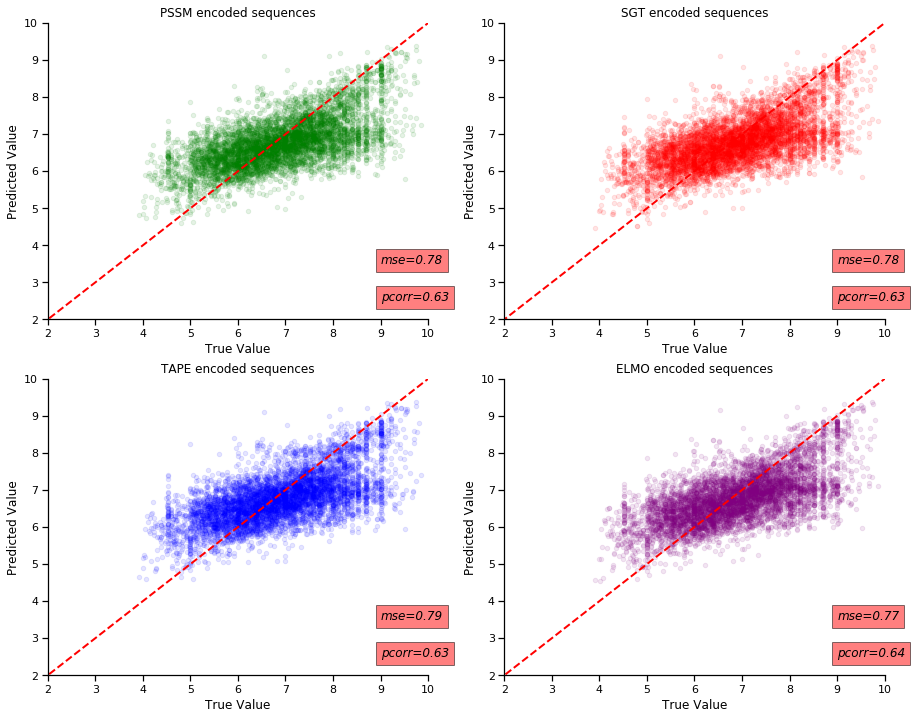

In [29]:
rf_predict_cluster = {}
sns.set_context('notebook')
encs = [pssmclust, sgtclust, tapeclust, elmoclust]
valid = [pssmclust_vl, sgtclust_vl, tapeclust_vl, elmoclust_vl]
names = ['PSSM encoded sequences', 'SGT encoded sequences','TAPE encoded sequences','ELMO encoded sequences']
col = ['green', 'red', 'blue', 'purple']
fig,axs=plt.subplots(2,2,figsize=(15,12))
axs=axs.flat
for i in range(len(encs)):
    rf_clustpred(encs[i], valid[i], 4, ax=axs[i], name=names, colors=col, predict= rf_predict_cluster)

In [37]:
rf_predict_cluster.keys()

dict_keys(['PSSM encoded sequences', 'SGT encoded sequences', 'TAPE encoded sequences', 'ELMO encoded sequences'])

In [41]:
pssmElmo = rf_predict_cluster['PSSM encoded sequences']
sgtElmo = rf_predict_cluster['SGT encoded sequences']
tapeElmo = rf_predict_cluster['TAPE encoded sequences']
elmoElmo = rf_predict_cluster['ELMO encoded sequences']

In [42]:
pssmElmo.to_csv('preds/pssmelmo.csv')
sgtElmo.to_csv('preds/sgtelmo.csv')
tapeElmo.to_csv('preds/tapeelmo.csv')
elmoElmo.to_csv('preds/elmoelmo.csv')

# Random forest cluster for tape

In [30]:
tapeclusters = pd.read_csv('tape_pro_cluster.csv')

In [31]:
pssmtapeclust = pssm.merge(tapeclusters,on="target_id")
sgttapeclust = sgt.merge(tapeclusters,on="target_id")
tapetapeclust = tape.merge(tapeclusters, on='target_id')
elmotapeclust = elmo.merge(tapeclusters, on='target_id')

In [32]:
pssmtapeclust_vl = pssm_vl.merge(tapeclusters,on="target_id")
sgttapeclust_vl = sgt_vl.merge(tapeclusters,on="target_id")
tapetapeclust_vl = tape_vl.merge(tapeclusters, on='target_id')
elmotapeclust_vl = elmo_vl.merge(tapeclusters, on='target_id')

In [34]:
def rf_tape_clustpred(encoder, validata, nclust, ax, name, colors, predict):
    predictions, truths = [], []
    for ind in range (0, nclust):
        reg = RandomForestRegressor(n_estimators=100,max_features=0.33,random_state=42)
        data = encoder[encoder.cluster == ind]
        val = validata[validata.cluster == ind]
        X_train = data.drop(['compound_id', 'target_id', 'pchembl_value', 'cluster'], axis=1)
        y_train = data['pchembl_value']
        X_test = val.drop(['compound_id', 'target_id', 'pchembl_value', 'cluster'], axis=1)
        y_test = val['pchembl_value']
        reg.fit(X_train, y_train)
        predictions += reg.predict(X_test).tolist()
        truths += y_test.tolist()
        joblib.dump(reg, f'models/{ind}_{name[i]}_rf_tapecluster.pkl')
    
    dfdict = {'True Value': truths, 'Predicted Value': predictions}
    df = pd.DataFrame(dfdict)
    predict[name[i]] = df
    df.plot('True Value', "Predicted Value" ,kind='scatter',s=20, ax=ax, color=colors[i], alpha=0.1)
    ax.plot((0,10), (0,10), ls="--", lw=2, c=".2", color='red')
    ax.set_xlim((2,10));  ax.set_ylim((2,10))
    pcorr = pearsonr(df['True Value'], df['Predicted Value'])[0]
    mse = mean_squared_error(df['True Value'], df['Predicted Value'])
    ax.set_title(name[i])
    ax.text(9,2.5,'pcorr=%s' %round(pcorr,2),style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    ax.text(9,3.5,'mse=%s' %round(mse,2), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
    sns.despine()
    

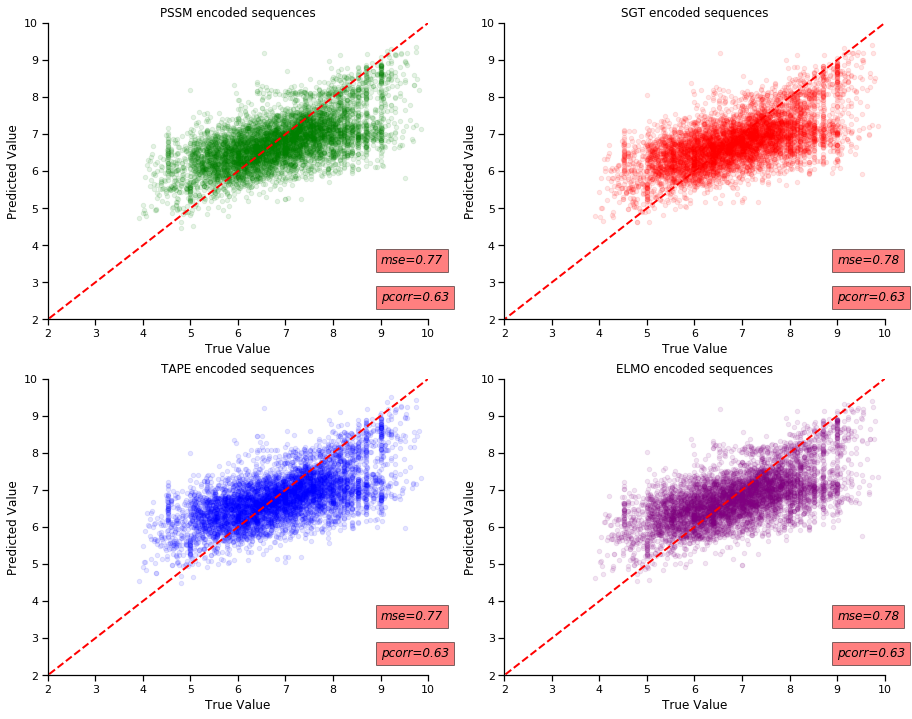

In [35]:
rf_predict_tapecluster = {}
sns.set_context('notebook')
encs = [pssmtapeclust, sgttapeclust, tapetapeclust, elmotapeclust]
valid = [pssmtapeclust_vl, sgttapeclust_vl, tapetapeclust_vl, elmotapeclust_vl]
names = ['PSSM encoded sequences', 'SGT encoded sequences','TAPE encoded sequences','ELMO encoded sequences']
col = ['green', 'red', 'blue', 'purple']
fig,axs=plt.subplots(2,2,figsize=(15,12))
axs=axs.flat
for i in range(len(encs)):
    rf_tape_clustpred(encs[i], valid[i], 3, ax=axs[i], name=names, colors=col, predict= rf_predict_tapecluster)

In [43]:
pssmtape = rf_predict_tapecluster['PSSM encoded sequences']
sgttape = rf_predict_tapecluster['SGT encoded sequences']
tapetape = rf_predict_tapecluster['TAPE encoded sequences']
elmotape = rf_predict_tapecluster['ELMO encoded sequences']

In [44]:
pssmtape.to_csv('preds/pssmtape.csv')
sgttape.to_csv('preds/sgttape.csv')
tapetape.to_csv('preds/tapetape.csv')
elmotape.to_csv('preds/elmotape.csv')